In [1]:
from zs6d import ZS6D
import os
import json


# Loading the config file:
with open(os.path.join("./zs6d_configs/bop_eval_configs/cfg_ycbv_inference_bop.json"), "r") as f:
    config = json.load(f)
    
# Instantiating the pose estimator:
# This involves handing over the path to the templates_gt file and the corresponding object norm_factors.
pose_estimator = ZS6D(config['templates_gt_path'], config['norm_factor_path'])

Using cache found in /home/kilian/.cache/torch/hub/facebookresearch_dino_main
100%|██████████| 21/21 [00:12<00:00,  1.70it/s]


Shape of img_prep: torch.Size([1, 3, 224, 224])
Shape of desc: torch.Size([1, 1, 3026, 384])
Shape of desc after squeeze: torch.Size([3026, 384])
Shape of self.templates_desc[obj_id] : torch.Size([43, 3026, 384])
Shape of desc_input: torch.Size([3026, 384])
Shape of desc_templates: torch.Size([43, 3026, 384])
Shape of desc_input_flat: torch.Size([1161984])
Shape of first template_flat: torch.Size([1161984])


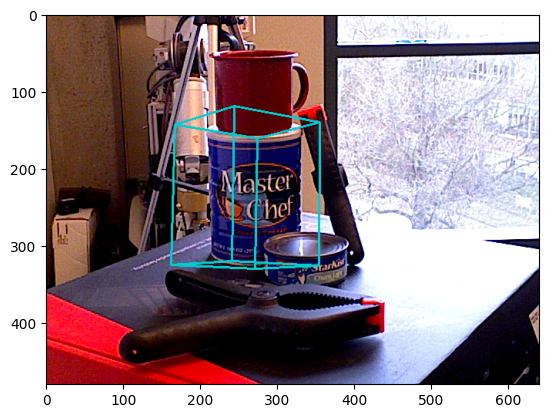

Pose estimation time: 13.212423086166382
R_est: [[-0.62785711  0.77828006 -0.00869455]
 [ 0.09479205  0.0875491   0.99163987]
 [ 0.77253474  0.62178396 -0.12874309]]
t_est: [  40.48456204    6.1193452  -804.84082597]
Shape of img_prep: torch.Size([1, 3, 224, 224])


KeyboardInterrupt: 

In [2]:
import cv2
from PIL import Image
import pose_utils.img_utils as img_utils
import pose_utils.vis_utils as vis_utils
import numpy as np
import time
import matplotlib.pyplot as plt

# Loading a ground truth file to access segmentation masks to test zs6d:
with open(os.path.join(config['gt_path']), 'r') as f:
    data_gt = json.load(f)

img_id = '000048_1'
# img_id = '8'



for i in range(len(data_gt[img_id])):
    obj_number = i
    obj_id = data_gt[img_id][obj_number]['obj_id']
    cam_K = np.array(data_gt[img_id][obj_number]['cam_K']).reshape((3,3))
    bbox = data_gt[img_id][obj_number]['bbox_visib']
    
    #img_path = os.path.join(config['dataset_path'], data_gt[img_id][obj_number]['img_name'].split("./")[-1])
    img_path = "./test/000001.png"

    img = Image.open(img_path)

    mask = data_gt[img_id][obj_number]['mask_sam']
    mask = img_utils.rle_to_mask(mask)
    mask = mask.astype(np.uint8)

    start_time = time.time()
    
    # To estimate the objects Rotation R and translation t the input image, the object_id, a segmentation mask and camera matrix are necessary
    R_est, t_est = pose_estimator.get_pose(img, str(obj_id), mask, cam_K, bbox=None)

    end_time = time.time()
    
    out_img = vis_utils.draw_3D_bbox_on_image(np.array(img), R_est, t_est, cam_K, data_gt[img_id][obj_number]['model_info'], factor=1.0)

    plt.imshow(out_img)
    plt.show()
    print(f"Pose estimation time: {end_time-start_time}")
    print(f"R_est: {R_est}")
    print(f"t_est: {t_est}")